In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from scipy.optimize import linear_sum_assignment
from src_numpy import (
    make_acoustic_ssm_np,
    simulate_acoustic_with_Q_real,
    particle_filter_numpy,
    particle_filter_edh,
)

In [ ]:
# OMAT

def compute_omat(xs_true, xs_est, num_targets=4, p=1):
    """
    Compute Optimal Mass Transfer (OMAT) metric for multi-target tracking.
    
    Args:
        xs_true: [T+1, nx] True states
        xs_est: [T+1, nx] or [T, nx] Estimated states
        num_targets: Number of targets (C)
        p: Power parameter (default 1)
        
    Returns:
        omat_per_step: [T] OMAT at each time step (excluding initial)
        omat_mean: Mean OMAT over all time steps
    """
    # Handle case where xs_est doesn't include initial state
    if xs_est.shape[0] == xs_true.shape[0] - 1:
        xs_true_aligned = xs_true[1:]  # Skip initial state
    else:
        xs_true_aligned = xs_true
    
    T = xs_true_aligned.shape[0]
    omat_per_step = np.zeros(T)
    
    for t in range(T):
        pos_true = np.zeros((num_targets, 2))
        pos_est = np.zeros((num_targets, 2))
        
        for c in range(num_targets):
            pos_true[c, 0] = xs_true_aligned[t, 4*c]
            pos_true[c, 1] = xs_true_aligned[t, 4*c + 1]
            pos_est[c, 0] = xs_est[t, 4*c]
            pos_est[c, 1] = xs_est[t, 4*c + 1]
        
        # Cost matrix
        cost_matrix = np.zeros((num_targets, num_targets))
        for i in range(num_targets):
            for j in range(num_targets):
                dist = np.sqrt(np.sum((pos_true[i] - pos_est[j])**2))
                cost_matrix[i, j] = dist ** p
        
        # Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total_cost = cost_matrix[row_ind, col_ind].sum()
        omat_per_step[t] = (total_cost / num_targets) ** (1/p)
    
    return omat_per_step, np.mean(omat_per_step)

In [ ]:
# Experimental Parameters

# Paper setup
N_TRAJECTORIES = 40      # Number of random trajectories
N_RUNS_PER_TRAJ = 5       # Number of runs per trajectory (different init)
T = 40                    # Time steps per trajectory
NUM_TARGETS = 4

# Particle counts
N_BOOTSTRAP = 10**5       # Bootstrap PF: 100,000 particles
N_PFPF = 500              # PF-PF: 500 particles


print(f"Experiment Setup:")
print(f"  Trajectories: {N_TRAJECTORIES}")
print(f"  Runs per trajectory: {N_RUNS_PER_TRAJ}")
print(f"  Total filter runs: {N_TRAJECTORIES * N_RUNS_PER_TRAJ}")
print(f"  Time steps: {T}")
print(f"  Bootstrap particles: {N_BOOTSTRAP:,}")
print(f"  PF-PF particles: {N_PFPF}")

Experiment Setup:
  Trajectories: 40
  Runs per trajectory: 5
  Total filter runs: 200
  Time steps: 40
  Bootstrap particles: 100,000
  PF-PF particles: 500


In [ ]:
# Create SSM with paper's Q for filtering
ssm = make_acoustic_ssm_np(
    num_targets=NUM_TARGETS,
    num_sensors_per_side=5,
    deterministic_init=False,
    use_paper_Q=True,
)

# True initial state
m0_true = ssm.m0.copy()

# sigma0 for sampling initial filter mean (from paper)
# Paper: sigma0 = repmat(10*[1;1;0.1;0.1], nTarget, 1) -> std = [10, 10, 1, 1]
sigma0 = ssm.sigma0  # [10, 10, 1, 1, 10, 10, 1, 1, ...]

print(f"True initial state (first target): {m0_true[:4]}")
print(f"sigma0 (first target): {sigma0[:4]}")
print(f"Q_filter diagonal (first target): {np.diag(ssm.Q_filter)[:4]}")
print(f"Q_real diagonal (first target): {np.diag(ssm.Q_real)[:4]}")

True initial state (first target): [1.2e+01 6.0e+00 1.0e-03 1.0e-03]
sigma0 (first target): [10. 10.  1.  1.]
Q_filter diagonal (first target): [3.000001 3.000001 0.030001 0.030001]
Q_real diagonal (first target): [0.01666767 0.01666767 0.050001   0.050001  ]


In [ ]:
# Simulation Function (using Q_realistic)
def simulate_trajectory(ssm, T, seed):
    """
    Simulate one trajectory using Q_real (paper's simulation noise).
    
    Paper: Q_real = (1/20) * Gamma where Gamma is defined in Eq. after Eq. 38
    """
    rng = np.random.default_rng(seed)
    nx = ssm.nx
    ny = ssm.ny
    
    # Simulate states with Q_real
    xs = [ssm.m0.copy()]
    x = ssm.m0.copy()
    for t in range(T):
        x = ssm.A @ x + rng.multivariate_normal(np.zeros(nx), ssm.Q_real)
        xs.append(x)
    xs = np.array(xs)  # [T+1, nx]
    
    # Generate observations
    ys = []
    for t in range(1, T + 1):
        y_mean = ssm.h_fn(xs[t:t+1])[0]
        y = y_mean + rng.multivariate_normal(np.zeros(ny), ssm.R)
        ys.append(y)
    ys = np.array(ys)  # [T, ny]
    
    return xs, ys


def sample_initial_mean(m0_true, sigma0, rng, bounds=(0, 40)):
    num_targets = len(m0_true) // 4
    
    while True:
        # Sample initial mean
        init_mean = m0_true + sigma0 * rng.standard_normal(len(m0_true))
        
        # Check bounds for all target positions
        valid = True
        for t in range(num_targets):
            px, py = init_mean[4*t], init_mean[4*t + 1]
            if px < bounds[0] or px > bounds[1] or py < bounds[0] or py > bounds[1]:
                valid = False
                break
        
        if valid:
            return init_mean

In [ ]:
# Shape: [N_TRAJECTORIES, N_RUNS_PER_TRAJ, T]
omat_bpf_all = np.zeros((N_TRAJECTORIES, N_RUNS_PER_TRAJ, T))
omat_edh_all = np.zeros((N_TRAJECTORIES, N_RUNS_PER_TRAJ, T))
ess_bpf_all = np.zeros((N_TRAJECTORIES, N_RUNS_PER_TRAJ, T))
ess_edh_all = np.zeros((N_TRAJECTORIES, N_RUNS_PER_TRAJ, T))

time_bpf_total = 0
time_edh_total = 0

print(f"Running experiment: {N_TRAJECTORIES} trajectories × {N_RUNS_PER_TRAJ} runs")
print("="*70)

for traj_idx in tqdm(range(N_TRAJECTORIES), desc="Trajectories"):
    # Simulate one trajectory
    traj_seed = 1000 + traj_idx
    xs_true, ys = simulate_trajectory(ssm, T, seed=traj_seed)
    
    for run_idx in range(N_RUNS_PER_TRAJ):
        # Sample different initial mean for this run
        init_seed = traj_idx * 1000 + run_idx
        rng_init = np.random.default_rng(init_seed)
        init_mean = sample_initial_mean(m0_true, sigma0, rng_init)
        
        # Create SSM copy with this initial mean
        ssm_run = make_acoustic_ssm_np(
            num_targets=NUM_TARGETS,
            deterministic_init=False,
            use_paper_Q=True,
        )
        ssm_run.m0 = init_mean
        
        # Filter seed (different from init seed)
        filter_seed = 5000 + traj_idx * 100 + run_idx
        
        # --- Run Bootstrap PF ---
        t0 = time.time()
        ms_bpf, _, info_bpf = particle_filter_numpy(
            ssm_run, ys,
            num_particles=N_BOOTSTRAP,
            resample="ess",
            ess_threshold=0.5,
            seed=filter_seed
        )
        time_bpf_total += time.time() - t0
        
        # --- Run PF-PF (EDH) ---
        t0 = time.time()
        ms_edh, _, info_edh = particle_filter_edh(
            ssm_run, ys,
            h_fn=ssm_run.h_fn,
            H_jac_fn=ssm_run.H_jac_fn,
            num_particles=N_PFPF,
            num_flow_steps=29,
            flow_step_ratio=1.2,
            resample="ess",
            ess_threshold=0.5,
            seed=filter_seed
        )
        time_edh_total += time.time() - t0
        
        # Compute OMAT
        omat_bpf, _ = compute_omat(xs_true, np.array(ms_bpf), NUM_TARGETS)
        omat_edh, _ = compute_omat(xs_true, np.array(ms_edh), NUM_TARGETS)
        
        # Store results
        omat_bpf_all[traj_idx, run_idx, :] = omat_bpf[1:]
        omat_edh_all[traj_idx, run_idx, :] = omat_edh[1:]
        ess_bpf_all[traj_idx, run_idx, :] = info_bpf['ess']
        ess_edh_all[traj_idx, run_idx, :] = info_edh['ess']

print("\nExperiment completed!")
print(f"Total Bootstrap PF time: {time_bpf_total:.1f}s")
print(f"Total PF-PF (EDH) time: {time_edh_total:.1f}s")

Running experiment: 40 trajectories × 5 runs


Trajectories: 100%|██████████| 40/40 [38:41<00:00, 58.03s/it]


Experiment completed!
Total Bootstrap PF time: 2284.2s
Total PF-PF (EDH) time: 36.0s


In [ ]:
# Average OMAT at each time step (over all trajectories and runs)
# Shape: [N_TRAJECTORIES * N_RUNS_PER_TRAJ, T] -> [T]
omat_bpf_flat = omat_bpf_all.reshape(-1, T)  # [N_total, T]
omat_edh_flat = omat_edh_all.reshape(-1, T)
ess_bpf_flat = ess_bpf_all.reshape(-1, T)
ess_edh_flat = ess_edh_all.reshape(-1, T)

# Mean and std over all runs
omat_bpf_mean_per_step = np.mean(omat_bpf_flat, axis=0)  # [T]
omat_edh_mean_per_step = np.mean(omat_edh_flat, axis=0)
omat_bpf_std_per_step = np.std(omat_bpf_flat, axis=0)
omat_edh_std_per_step = np.std(omat_edh_flat, axis=0)

ess_bpf_mean_per_step = np.mean(ess_bpf_flat, axis=0)
ess_edh_mean_per_step = np.mean(ess_edh_flat, axis=0)
ess_bpf_std_per_step = np.std(ess_bpf_flat, axis=0)
ess_edh_std_per_step = np.std(ess_edh_flat, axis=0)

# Overall statistics
omat_bpf_overall = np.mean(omat_bpf_flat)
omat_edh_overall = np.mean(omat_edh_flat)
ess_bpf_overall = np.mean(ess_bpf_flat)
ess_edh_overall = np.mean(ess_edh_flat)

print("="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"{'Method':<20} | {'Particles':>10} | {'Avg OMAT':>10} | {'Avg ESS':>10} | {'ESS %':>8}")
print("-"*70)
print(f"{'Bootstrap PF':<20} | {N_BOOTSTRAP:>10,} | {omat_bpf_overall:>10.4f} | {ess_bpf_overall:>10.1f} | {100*ess_bpf_overall/N_BOOTSTRAP:>7.3f}%")
print(f"{'PF-PF (EDH)':<20} | {N_PFPF:>10} | {omat_edh_overall:>10.4f} | {ess_edh_overall:>10.1f} | {100*ess_edh_overall/N_PFPF:>7.3f}%")
print("-"*70)

SUMMARY STATISTICS
Method               |  Particles |   Avg OMAT |    Avg ESS |    ESS %
----------------------------------------------------------------------
Bootstrap PF         |    100,000 |     3.5292 |      932.8 |   0.933%
PF-PF (EDH)          |        500 |     6.6793 |       17.5 |   3.502%
----------------------------------------------------------------------


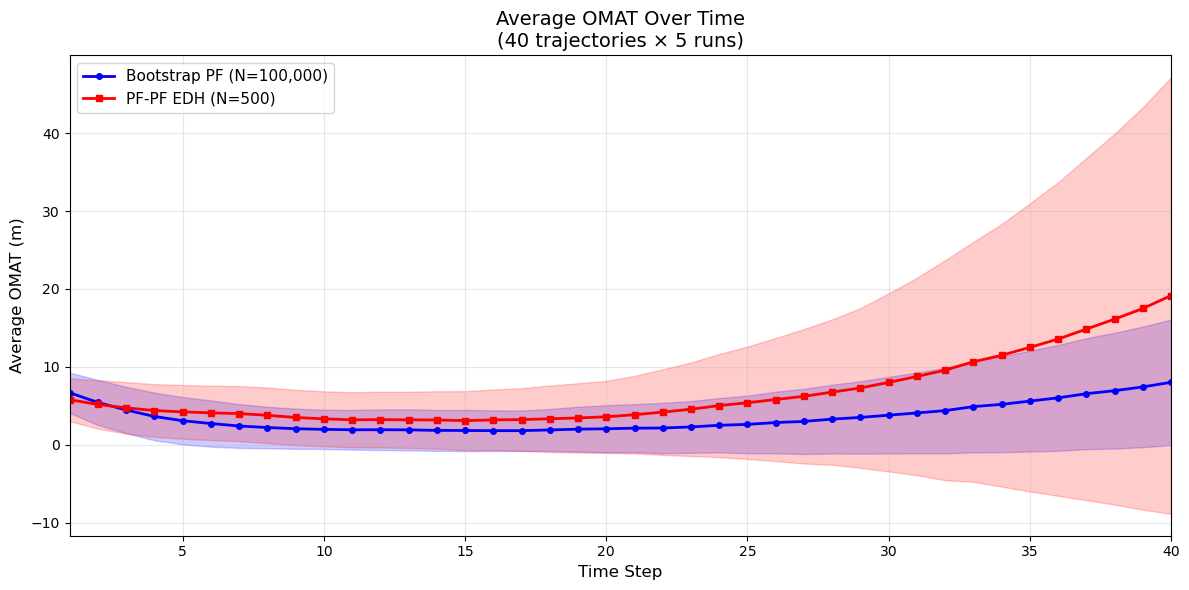

In [ ]:
# Plot Average OMAT Over Time (like Figure 2 in paper)

fig, ax = plt.subplots(figsize=(12, 6))

t = np.arange(1, T + 1)

# Plot mean with shaded std region
ax.plot(t, omat_bpf_mean_per_step, 'b-', lw=2, marker='o', markersize=4, 
        label=f'Bootstrap PF (N={N_BOOTSTRAP:,})')
ax.fill_between(t, 
                omat_bpf_mean_per_step - omat_bpf_std_per_step,
                omat_bpf_mean_per_step + omat_bpf_std_per_step,
                alpha=0.2, color='blue')

ax.plot(t, omat_edh_mean_per_step, 'r-', lw=2, marker='s', markersize=4,
        label=f'PF-PF EDH (N={N_PFPF})')
ax.fill_between(t,
                omat_edh_mean_per_step - omat_edh_std_per_step,
                omat_edh_mean_per_step + omat_edh_std_per_step,
                alpha=0.2, color='red')

ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Average OMAT (m)', fontsize=12)
ax.set_title(f'Average OMAT Over Time\n({N_TRAJECTORIES} trajectories × {N_RUNS_PER_TRAJ} runs)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([1, T])

plt.tight_layout()
plt.savefig('omat_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

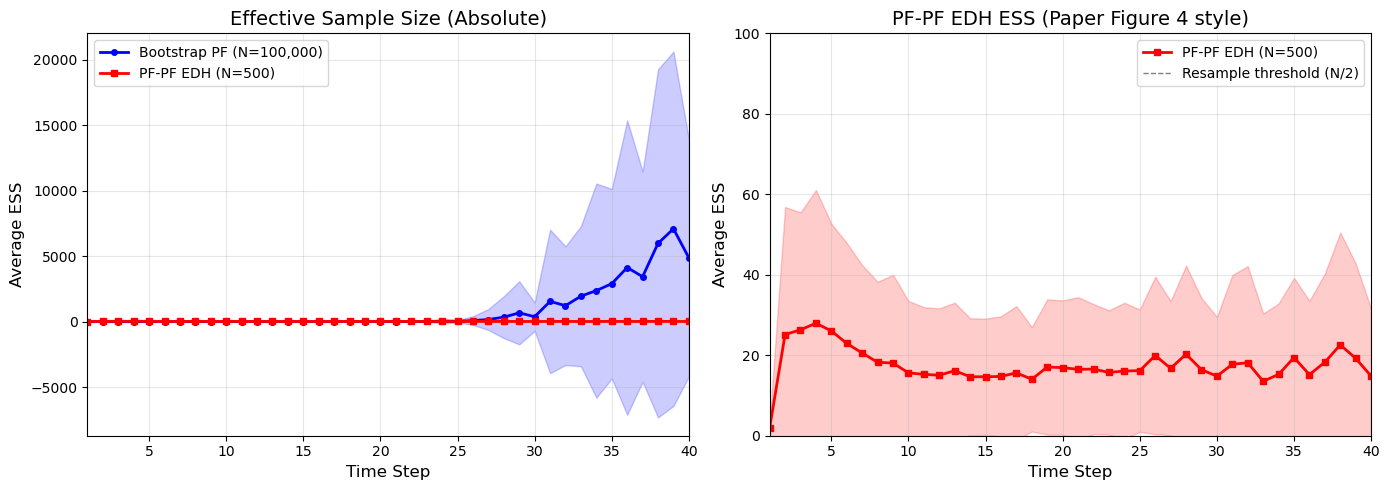


Average ESS:
  Bootstrap PF: 932.8 / 100,000 (0.9328%)
  PF-PF (EDH):  17.5 / 500 (3.50%)


In [ ]:
# Plot Average ESS Over Time (like Figure 4 in paper)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

t = np.arange(1, T + 1)

ax = axes[0]

ax.plot(t, ess_bpf_mean_per_step, 'b-', lw=2, marker='o', markersize=4,
        label=f'Bootstrap PF (N={N_BOOTSTRAP:,})')
ax.fill_between(t,
                ess_bpf_mean_per_step - ess_bpf_std_per_step,
                ess_bpf_mean_per_step + ess_bpf_std_per_step,
                alpha=0.2, color='blue')

ax.plot(t, ess_edh_mean_per_step, 'r-', lw=2, marker='s', markersize=4,
        label=f'PF-PF EDH (N={N_PFPF})')
ax.fill_between(t,
                ess_edh_mean_per_step - ess_edh_std_per_step,
                ess_edh_mean_per_step + ess_edh_std_per_step,
                alpha=0.2, color='red')

ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Average ESS', fontsize=12)
ax.set_title('Effective Sample Size (Absolute)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([1, T])

ax = axes[1]

ax.plot(t, ess_edh_mean_per_step, 'r-', lw=2, marker='s', markersize=4,
        label=f'PF-PF EDH (N={N_PFPF})')
ax.fill_between(t,
                ess_edh_mean_per_step - ess_edh_std_per_step,
                ess_edh_mean_per_step + ess_edh_std_per_step,
                alpha=0.2, color='red')

ax.axhline(N_PFPF/2, color='k', ls='--', lw=1, alpha=0.5, label='Resample threshold (N/2)')

ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Average ESS', fontsize=12)
ax.set_title(f'PF-PF EDH ESS (Paper Figure 4 style)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([1, T])
ax.set_ylim([0, max(100, np.max(ess_edh_mean_per_step + ess_edh_std_per_step) * 1.1)])

plt.tight_layout()
plt.savefig('ess_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAverage ESS:")
print(f"  Bootstrap PF: {ess_bpf_overall:.1f} / {N_BOOTSTRAP:,} ({100*ess_bpf_overall/N_BOOTSTRAP:.4f}%)")
print(f"  PF-PF (EDH):  {ess_edh_overall:.1f} / {N_PFPF} ({100*ess_edh_overall/N_PFPF:.2f}%)")

In [ ]:
omat_bpf_per_traj = np.mean(omat_bpf_all, axis=(1, 2))  # [N_TRAJECTORIES]
omat_edh_per_traj = np.mean(omat_edh_all, axis=(1, 2))
ess_bpf_per_traj = np.mean(ess_bpf_all, axis=(1, 2))
ess_edh_per_traj = np.mean(ess_edh_all, axis=(1, 2))

print("="*80)
print("RESULTS TABLE (Paper Table I style)")
print("="*80)
print(f"Experiment: {N_TRAJECTORIES} trajectories × {N_RUNS_PER_TRAJ} runs = {N_TRAJECTORIES * N_RUNS_PER_TRAJ} total runs")
print(f"Time steps per trajectory: {T}")
print("-"*80)
print(f"{'Method':<20} | {'N':>8} | {'OMAT Mean':>10} | {'OMAT Std':>10} | {'ESS Mean':>10} | {'Time/run':>10}")
print("-"*80)

n_total_runs = N_TRAJECTORIES * N_RUNS_PER_TRAJ
print(f"{'Bootstrap PF':<20} | {N_BOOTSTRAP:>8,} | {np.mean(omat_bpf_per_traj):>10.4f} | {np.std(omat_bpf_per_traj):>10.4f} | {np.mean(ess_bpf_per_traj):>10.1f} | {time_bpf_total/n_total_runs:>10.2f}s")
print(f"{'PF-PF (EDH)':<20} | {N_PFPF:>8} | {np.mean(omat_edh_per_traj):>10.4f} | {np.std(omat_edh_per_traj):>10.4f} | {np.mean(ess_edh_per_traj):>10.1f} | {time_edh_total/n_total_runs:>10.2f}s")
print("-"*80)

RESULTS TABLE (Paper Table I style)
Experiment: 40 trajectories × 5 runs = 200 total runs
Time steps per trajectory: 40
--------------------------------------------------------------------------------
Method               |        N |  OMAT Mean |   OMAT Std |   ESS Mean |   Time/run
--------------------------------------------------------------------------------
Bootstrap PF         |  100,000 |     3.5292 |     1.7904 |      932.8 |      11.42s
PF-PF (EDH)          |      500 |     6.6793 |     4.6356 |       17.5 |       0.18s
--------------------------------------------------------------------------------


/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_42718/3760738701.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


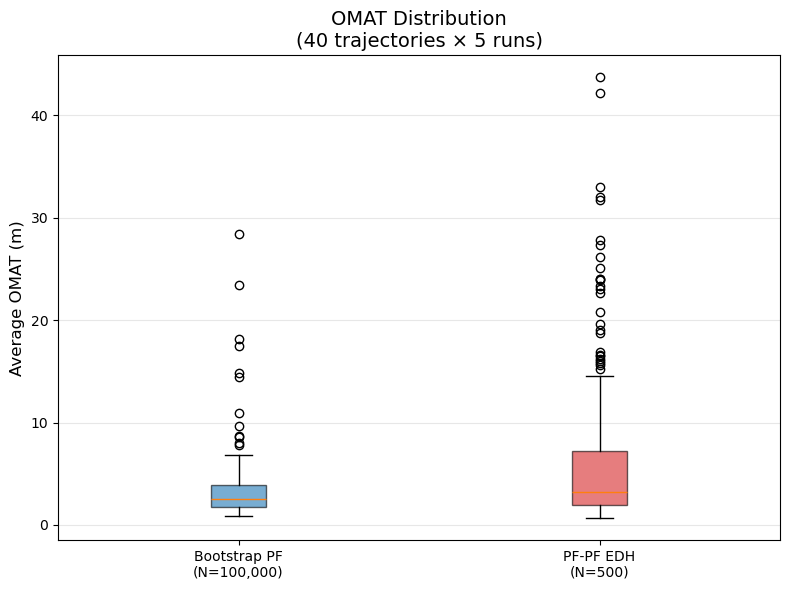

In [ ]:
# OMAT Box plot

fig, ax = plt.subplots(figsize=(8, 6))

# Per-run average OMAT
omat_bpf_per_run = np.mean(omat_bpf_flat, axis=1)  # [N_total]
omat_edh_per_run = np.mean(omat_edh_flat, axis=1)

data = [omat_bpf_per_run, omat_edh_per_run]
labels = [f'Bootstrap PF\n(N={N_BOOTSTRAP:,})', f'PF-PF EDH\n(N={N_PFPF})']

bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = ['tab:blue', 'tab:red']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Average OMAT (m)', fontsize=12)
ax.set_title(f'OMAT Distribution\n({N_TRAJECTORIES} trajectories × {N_RUNS_PER_TRAJ} runs)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('omat_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

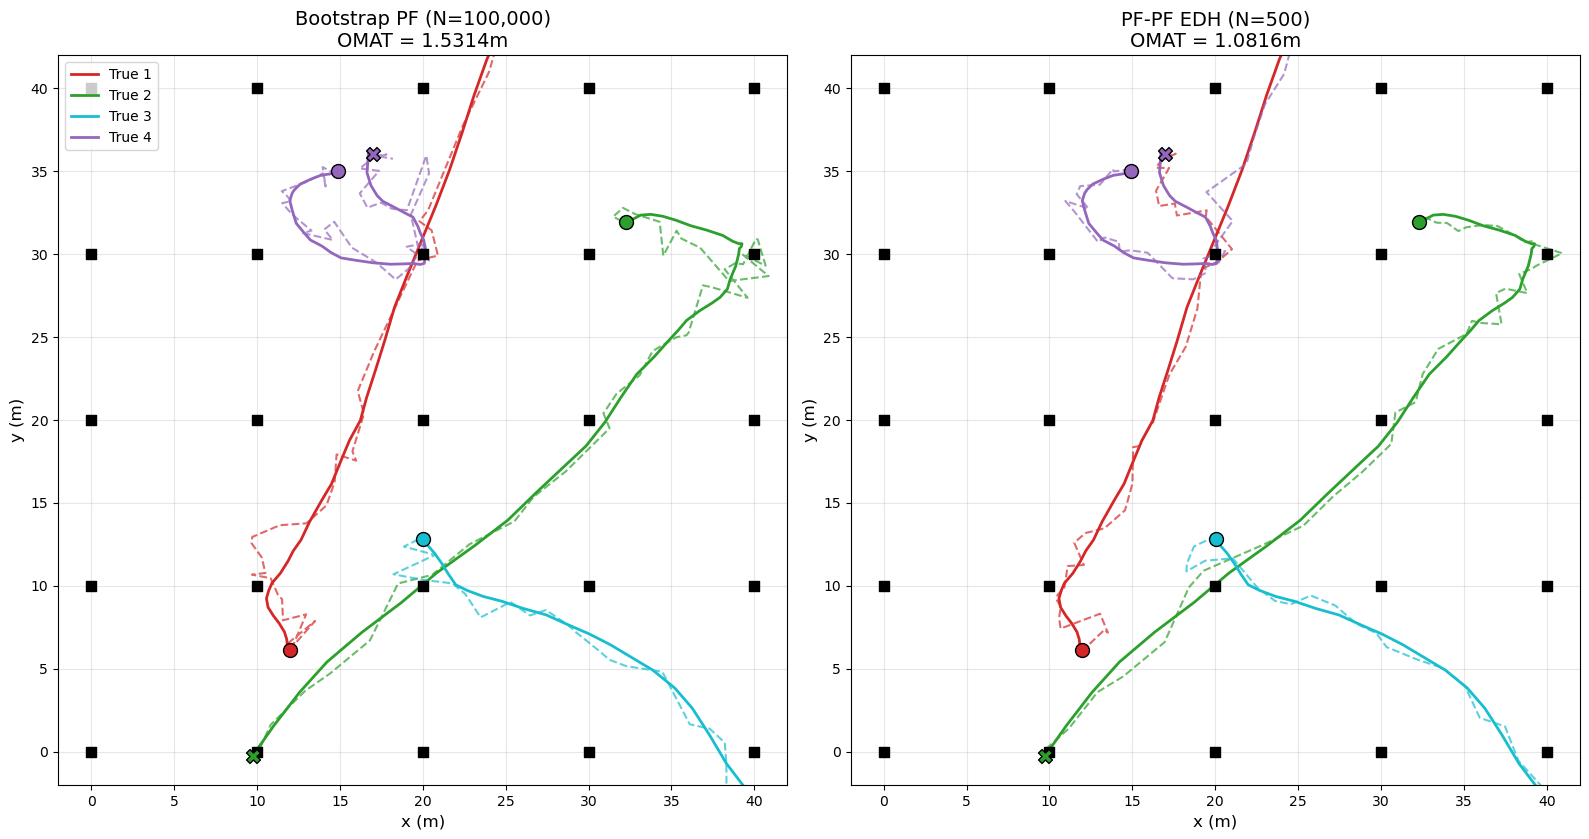

In [ ]:
# Sample Trajectory Comparison

traj_seed = 42
xs_true, ys = simulate_trajectory(ssm, T, seed=traj_seed)

ssm_plot = make_acoustic_ssm_np(
    num_targets=NUM_TARGETS,
    deterministic_init=False,
    use_paper_Q=True,
)

ms_bpf, _, info_bpf = particle_filter_numpy(
    ssm_plot, ys,
    num_particles=N_BOOTSTRAP,
    resample="ess",
    ess_threshold=0.5,
    seed=123
)

ms_edh, _, info_edh = particle_filter_edh(
    ssm_plot, ys,
    h_fn=ssm_plot.h_fn,
    H_jac_fn=ssm_plot.H_jac_fn,
    num_particles=N_PFPF,
    num_flow_steps=29,
    flow_step_ratio=1.2,
    resample="ess",
    ess_threshold=0.5,
    seed=123
)

ms_bpf = np.array(ms_bpf)
ms_edh = np.array(ms_edh)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

colors = ['tab:red', 'tab:green', 'tab:cyan', 'tab:purple']
sensor_1d = np.linspace(0, 40, 5)
sensor_xx, sensor_yy = np.meshgrid(sensor_1d, sensor_1d)

for ax_idx, (ax, ms, title, omat_val) in enumerate([
    (axes[0], ms_bpf, f'Bootstrap PF (N={N_BOOTSTRAP:,})', compute_omat(xs_true, ms_bpf, NUM_TARGETS)[1]),
    (axes[1], ms_edh, f'PF-PF EDH (N={N_PFPF})', compute_omat(xs_true, ms_edh, NUM_TARGETS)[1])
]):
    ax.set_xlim(-2, 42)
    ax.set_ylim(-2, 42)
    ax.grid(True, alpha=0.3)
    
    for c in range(NUM_TARGETS):
        px_idx = c * 4
        py_idx = c * 4 + 1
        
        # True trajectory
        ax.plot(xs_true[1:, px_idx], xs_true[1:, py_idx], 
                color=colors[c], linewidth=2, label=f'True {c+1}' if ax_idx == 0 else None)
        
        # Estimated trajectory
        ax.plot(ms[:, px_idx], ms[:, py_idx], 
                color=colors[c], linewidth=1.5, linestyle='--', alpha=0.7)
        
        # Markers
        ax.scatter(xs_true[1, px_idx], xs_true[1, py_idx], 
                   color=colors[c], s=100, marker='o', edgecolors='black', zorder=5)
        ax.scatter(xs_true[-1, px_idx], xs_true[-1, py_idx], 
                   color=colors[c], s=100, marker='X', edgecolors='black', zorder=5)
    
    # Sensors
    ax.scatter(sensor_xx.ravel(), sensor_yy.ravel(), 
               color='black', s=50, marker='s', zorder=4)
    
    ax.set_xlabel('x (m)', fontsize=12)
    ax.set_ylabel('y (m)', fontsize=12)
    ax.set_title(f'{title}\nOMAT = {omat_val:.4f}m', fontsize=14)
    ax.set_aspect('equal')

axes[0].legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('trajectory_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
results = {
    'N_TRAJECTORIES': N_TRAJECTORIES,
    'N_RUNS_PER_TRAJ': N_RUNS_PER_TRAJ,
    'T': T,
    'N_BOOTSTRAP': N_BOOTSTRAP,
    'N_PFPF': N_PFPF,
    'omat_bpf_all': omat_bpf_all,
    'omat_edh_all': omat_edh_all,
    'ess_bpf_all': ess_bpf_all,
    'ess_edh_all': ess_edh_all,
    'time_bpf_total': time_bpf_total,
    'time_edh_total': time_edh_total,
}

np.savez('experiment_results.npz', **results)
print("Results saved to experiment_results.npz")